In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [27]:
torch.set_default_dtype(torch.double)

In [28]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [29]:
# Define model
class SingleNeuron(nn.Module):
    def __init__(self):
        super(SingleNeuron, self).__init__()
        self.neuron = nn.Linear(1, 1)

    def forward(self, x):
        x = self.neuron(x)
        return x

model = SingleNeuron().to(device)
print(model)

SingleNeuron(
  (neuron): Linear(in_features=1, out_features=1, bias=True)
)


In [30]:
# Define Data
class Constant(Dataset):
    def __init__(self, input_distribution, target, size, seed=0, **kwargs):
        rng = np.random.default_rng(seed)
        self.x = input_distribution(rng, size=size, **kwargs)
        self.x = torch.tensor(self.x).double()
        self.y = torch.tensor(target).double()
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y

In [31]:
training_data = Constant(np.random.Generator.uniform, 0, 100, seed=0)
test_data = Constant(np.random.Generator.uniform, 0, 500, seed=123)

In [32]:
train_dataloader = DataLoader(training_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)

In [33]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [36]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.002453  [    0/  100]
Test Error: Avg loss: 0.131074 

Epoch 2
-------------------------------
loss: 0.115290  [    0/  100]
Test Error: Avg loss: 0.108147 

Epoch 3
-------------------------------
loss: 0.003385  [    0/  100]
Test Error: Avg loss: 0.092964 

Epoch 4
-------------------------------
loss: 0.074361  [    0/  100]
Test Error: Avg loss: 0.082916 

Epoch 5
-------------------------------
loss: 0.028445  [    0/  100]
Test Error: Avg loss: 0.075770 

Done!


# Vanilla Polynomial Learning

In [ ]:
torch.log(x)
torch.log(1 + nn.RelU(x))

In [1132]:
class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(1+x)
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

In [1133]:
# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_variables=1, n_monomials=1):
        super(PolynomialNN, self).__init__()
        self.dense_stack = nn.Sequential(
            nn.Linear(1, n_variables),
            nn.ReLU(),
            LogActivation(),
            nn.Linear(n_variables, n_monomials),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        
    def forward(self, x):
        x = self.dense_stack(x)
        return x

torch.manual_seed(638726)
model = PolynomialNN(100, 50).to(device)
print(model)

PolynomialNN(
  (dense_stack): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): LogActivation()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ExpActivation()
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [1134]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None):
        self.x = sample_fn(size)[:, None]
        self.y = target_fn(self.x)
        if noise_fn:
            self.y += noise_fn(size)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

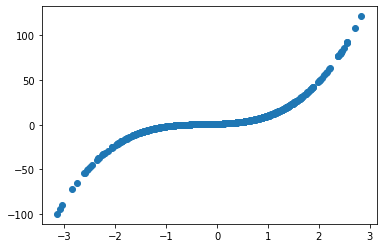

In [1135]:
rng = torch.Generator(device=device)
rng.manual_seed(0)
sample_fn = lambda n: torch.normal(0, 1, (n,), generator=rng)
target_fn = lambda x: 4*x**3 + 3*x**2 + 2*x + 1
training_data = DatasetFromFunction(sample_fn, target_fn, 1000)
test_data = DatasetFromFunction(sample_fn, target_fn, 100)

plt.scatter(training_data[:][0], training_data[:][1])

In [1136]:
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [1137]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [1138]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [1139]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [1140]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 184.260055  [    0/ 1000]
Test Error: Avg loss: 604.075511 

Epoch 2
-------------------------------
loss: 179.049334  [    0/ 1000]
Test Error: Avg loss: 599.541352 

Epoch 3
-------------------------------
loss: 371.403085  [    0/ 1000]
Test Error: Avg loss: 595.169476 

Epoch 4
-------------------------------
loss: 308.379672  [    0/ 1000]
Test Error: Avg loss: 590.735478 

Epoch 5
-------------------------------
loss: 296.677603  [    0/ 1000]
Test Error: Avg loss: 586.007544 

Epoch 6
-------------------------------
loss: 379.790883  [    0/ 1000]
Test Error: Avg loss: 580.877083 

Epoch 7
-------------------------------
loss: 147.860933  [    0/ 1000]
Test Error: Avg loss: 575.148605 

Epoch 8
-------------------------------
loss: 343.649169  [    0/ 1000]
Test Error: Avg loss: 568.516951 

Epoch 9
-------------------------------
loss: 258.963526  [    0/ 1000]
Test Error: Avg loss: 560.388698 

Epoch 10
----------------------------

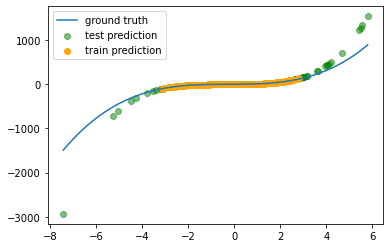

In [1143]:
train_x = training_data[:][0]
test_x = test_data[:][0]
test_x = torch.normal(0, 3, (100,), generator=rng)[:, None]
x = torch.cat((train_x, test_x))
x = torch.from_numpy(np.linspace(x.min(), x.max(), 200))

model.eval()
plt.plot(x, target_fn(x), label="ground truth")
plt.scatter(test_x, model(test_x).detach(), c="green", alpha=0.5, label="test prediction")
plt.scatter(train_x, model(train_x).detach(), c="orange", alpha=1, label="train prediction")
plt.legend()

# Vanilla Polynomial Learning with L1 regularized exponents

In [1062]:
class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(1+x)
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

In [1040]:
class L1(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L1 regularization formula
        return self.weight_decay * torch.sign(parameter.data)

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)

In [1041]:
# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_variables=1, n_monomials=1, l1 = 1.0):
        super(PolynomialNN, self).__init__()
        self.dense_stack = nn.Sequential(
            nn.Linear(1, n_variables),
            nn.ReLU(),
            LogActivation(),
            L1(nn.Linear(n_variables, n_monomials), l1),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        self.l1 = l1
        
    def forward(self, x):
        x = self.dense_stack(x)
        return x        

torch.manual_seed(638726)
model = PolynomialNN(100, 10, l1=0.0).to(device)
print(model)

PolynomialNN(
  (dense_stack): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): LogActivation()
    (3): L1(
      (module): Linear(in_features=100, out_features=10, bias=True)
    )
    (4): ExpActivation()
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [1030]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None):
        self.x = sample_fn(size)[:, None]
        self.y = target_fn(self.x)
        if noise_fn:
            self.y += noise_fn(size)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

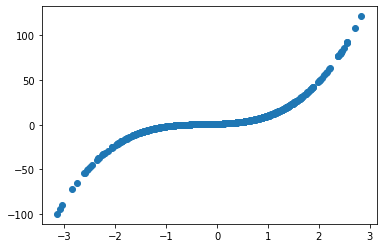

In [1031]:
rng = torch.Generator(device=device)
rng.manual_seed(0)
sample_fn = lambda n: torch.normal(0, 1, (n,), generator=rng)
target_fn = lambda x: 4*x**3 + 3*x**2 + 2*x + 1
training_data = DatasetFromFunction(sample_fn, target_fn, 1000)
test_data = DatasetFromFunction(sample_fn, target_fn, 100)

plt.scatter(training_data[:][0], training_data[:][1])

In [1032]:
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [1033]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [1035]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [1036]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [1037]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 454.279593  [    0/ 1000]
Test Error: Avg loss: 613.764459 

Epoch 2
-------------------------------
loss: 449.542382  [    0/ 1000]
Test Error: Avg loss: 612.690602 

Epoch 3
-------------------------------
loss: 366.202474  [    0/ 1000]
Test Error: Avg loss: 611.658042 

Epoch 4
-------------------------------
loss: 216.077218  [    0/ 1000]
Test Error: Avg loss: 610.634239 

Epoch 5
-------------------------------
loss: 424.400219  [    0/ 1000]
Test Error: Avg loss: 609.670249 

Epoch 6
-------------------------------
loss: 394.847704  [    0/ 1000]
Test Error: Avg loss: 608.729353 

Epoch 7
-------------------------------
loss: 335.022427  [    0/ 1000]
Test Error: Avg loss: 607.807991 

Epoch 8
-------------------------------
loss: 162.656430  [    0/ 1000]
Test Error: Avg loss: 606.929467 

Epoch 9
-------------------------------
loss: 326.846974  [    0/ 1000]
Test Error: Avg loss: 606.069677 

Epoch 10
----------------------------

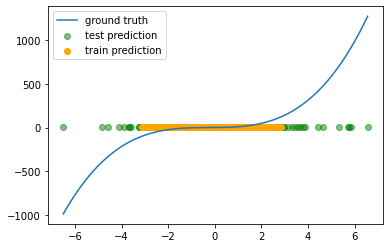

In [1038]:
train_x = training_data[:][0]
test_x = test_data[:][0]
test_x = torch.normal(0, 3, (100,), generator=rng)[:, None]
x = torch.cat((train_x, test_x))
x = torch.from_numpy(np.linspace(x.min(), x.max(), 200))

model.eval()
plt.plot(x, target_fn(x), label="ground truth")
plt.scatter(test_x, model(test_x).detach(), c="green", alpha=0.5, label="test prediction")
plt.scatter(train_x, model(train_x).detach(), c="orange", alpha=1, label="train prediction")
plt.legend()

In [1024]:
model.dense_stack[3].weight.max()

tensor(0.0992, grad_fn=<MaxBackward1>)